# Run CONCERT on perturb-map data

In [1]:
import os
import torch
import scanpy as sc
import h5py
import numpy as np
import pandas as pd

/root/code/26-02/CONCERT/.venv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/root/code/26-02/CONCERT/.venv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/root/code/26-02/CONCERT/.venv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/root/code/26-02/CONCERT/.venv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/root/code/26-02/CONCERT/.venv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `

In [2]:
os.chdir("../src/")
os.getcwd()

'/root/code/26-02/CONCERT/src'

## Load some auxiliary functions

In [3]:
#Some auxiliary functions
def pairwise_distance_quantile_numpy(loc, quantile=0.1):
    # Compute condensed pairwise distance matrix (1D array of upper triangle)
    dists = pdist(loc, metric='euclidean')  # shape: (N * (N - 1) / 2,)

    # Compute quantile
    q = np.quantile(dists, quantile)

    return q

def str_list_to_unique_index(str_list):
        original_numbers = np.array([sum(ord(char) for char in s) for s in str_list])
        renumbered = {num: idx + 1 for idx, num in enumerate(sorted(set(original_numbers)))}
        new_numbers = [renumbered[num] for num in original_numbers]
        return np.array(new_numbers)

## Read perturb-map data

In [5]:
data_mat = h5py.File('../datasets/29198468/GSM5808057_data.h5', 'r')
x = np.array(data_mat['X']).astype('float32') # count matrix
loc = np.array(data_mat['pos']).T.astype('float32') # location information
perturbation_ = np.array(data_mat['perturbation']).astype('str') # perturbation + tissue info, need to dicipher
pert_values = ['Jak2', 'Tgfbr2', 'Ifngr2']
#revalue perturbation for better understanding
tissue_ = perturbation_.copy()
tissue_ = np.array(['KP' if t in pert_values else t for t in tissue_])
tissue_ = np.array(['tumor' if t == 'KP' else t for t in tissue_])
tissue_ = np.array(['normal' if t == 'None' else t for t in tissue_])
tissue = str_list_to_unique_index(tissue_) - 1
unique_values = [val for val in pert_values if val in perturbation_]
mapping = {val: idx + 1 for idx, val in enumerate(unique_values)}
perturbation = np.vectorize(lambda x: mapping.get(x, 0))(perturbation_)
cell_atts = np.concatenate((tissue[:, None], perturbation[:, None]), axis=1)
sample_indices = torch.tensor(np.arange(x.shape[0]), dtype=torch.int)
num_classes = len(np.unique(perturbation))
batch = np.eye(num_classes)[perturbation].astype('float32')
n_batch = batch.shape[1]
data_mat.close()

print(np.unique(tissue_, return_counts=True))
print(np.unique(perturbation, return_counts=True))

tissue_dic = {tissue_[i]: tissue[i] for i in range(len(tissue_))}
pert_dic = mapping
print("tissue_dic", tissue_dic)
print("pert_dic", pert_dic)

(array(['normal', 'periphery', 'tumor'], dtype='<U9'), array([902, 104, 349]))
(array([0, 1]), array([1268,   87]))
tissue_dic {'tumor': 0, 'normal': 1, 'periphery': 2}
pert_dic {'Tgfbr2': 1}


## Setup batch size

In [6]:
if x.shape[0] <= 1024:
    batch_size = 128
elif x.shape[0] <= 2048:
    batch_size = 256
else:
    batch_size = 512

## Scale spot coordinates for training; setup cutoff

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
loc_range = 20
loc = scaler.fit_transform(loc) * loc_range
loc_dim = loc.shape[1]
cutoff = np.ones(loc.shape[0], dtype=np.float32) * 0.5
print(f"cutoff: {cutoff}")
loc = np.concatenate((loc, batch), axis=1)

# set learnable scales per dimensionanlity of kernel and per perturbation
kernel_scale = 10
kernel_scale = np.array([[kernel_scale] * loc_dim] * n_batch) 
print(f"Initial kernel scales {kernel_scale}")
print(f"Initial kernel scale shapes {kernel_scale.shape}")

cutoff: [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Initial kernel scales [[10 10]
 [10 10]]
Initial kernel scale shapes (2, 2)


## Setup inducing points

In [8]:
eps = 1e-5
inducing_point_steps = 6
initial_inducing_points = np.mgrid[0:(1+eps):(1./inducing_point_steps), 0:(1+eps):(1./inducing_point_steps)].reshape(2, -1).T * loc_range
print(initial_inducing_points.shape)
## add one-hot batch matrix for batch 0
initial_inducing_points_1 = np.zeros((initial_inducing_points.shape[0], n_batch))
initial_inducing_points_1[:, 0] = 1
initial_inducing_points = np.concatenate((initial_inducing_points, initial_inducing_points_1), axis=1)

(49, 2)


## Normalize data

In [9]:
from preprocess import normalize
adata = sc.AnnData(x, dtype="float32")
adata = normalize(adata,size_factors=True,normalize_input=True,logtrans_input=True)

/root/code/26-02/CONCERT/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


## Setup parameters and build model

In [12]:
from concert_map import CONCERT
Normal_dim = 8
GP_dim = 2
encoder_layers = [128, 64]
decoder_layers = [128]
noise = 0.25
dropoutE = 0
dropoutD = 0
KL_loss = 0.025
init_beta = 10
min_beta = 5
max_beta = 25
device = "cuda"

model = CONCERT(cell_atts=cell_atts, num_genes=adata.n_vars, encoder_dim=256, GP_dim=GP_dim, Normal_dim=Normal_dim, n_batch=n_batch, encoder_layers=encoder_layers, decoder_layers=decoder_layers,
        noise = 0.25, encoder_dropout=dropoutE, decoder_dropout=dropoutD, shared_dispersion=False,
        fixed_inducing_points=True, initial_inducing_points=initial_inducing_points, 
        fixed_gp_params=False, kernel_scale=kernel_scale, multi_kernel_mode=False, #allow_batch_kernel_scale=True,
        N_train=adata.n_obs, KL_loss=KL_loss, dynamicVAE=True, init_beta=init_beta, min_beta=min_beta, max_beta=max_beta, 
        mask_cutoff=cutoff, dtype=torch.float32, device=device)

/root/code/26-02/CONCERT/src/kernel.py:208: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.scale = nn.Parameter(torch.tensor([scale], dtype=dtype).to(device), requires_grad=True)


## Train model

In [13]:
from time import time
t0 = time()
num_samples = 1
weight_decay = 1e-6
lr = 1e-4
train_size = 0.95
maxiter = 5000
patience = 200
model_file = 'model.pt'

model.train_model(pos=loc, ncounts=adata.X, raw_counts=adata.raw.X, size_factors=adata.obs.size_factors, batch=batch,
                lr=lr, weight_decay=weight_decay, batch_size=batch_size, num_samples=num_samples,
                train_size=train_size, maxiter=maxiter, patience=patience, save_model=True, model_weights=model_file)

print('Training time: %d seconds.' % int(time() - t0))

/root/code/26-02/CONCERT/src/concert_map.py:869: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(size_factors),


RuntimeError: The size of tensor a (49) must match the size of tensor b (2) at non-singleton dimension 1

## Extract learned cutoff for spots and visualize

In [12]:
cutoff = model.mask_cutoff.detach().cpu().numpy()
df = pd.DataFrame({'cutoff': cutoff, 'Group': perturbation_})

/tmp/ipykernel_27788/2750261188.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='cutoff', data=df, palette='Set2')


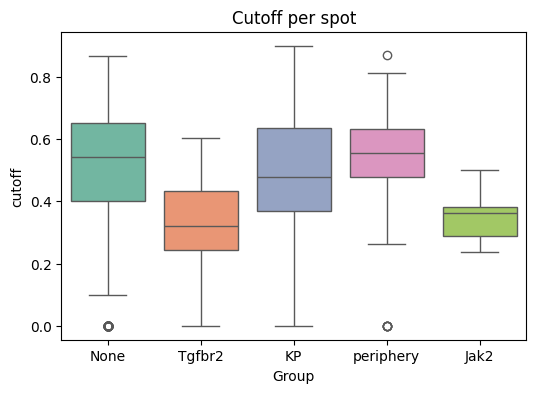

In [19]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(x='Group', y='cutoff', data=df, palette='Set2')
plt.title('Cutoff per spot')
plt.show()

## Extract latent space and visualize

In [ ]:
final_latent = model.batching_latent_samples(X=loc, sample_index=sample_indices, cell_atts=cell_atts, batch_size=batch_size)

In [40]:
fil = np.where(np.isin(perturbation_, ['Jak2', 'Tgfbr2', 'KP']))[0]
final_latent_ = final_latent[fil,:]
label = perturbation_[fil]

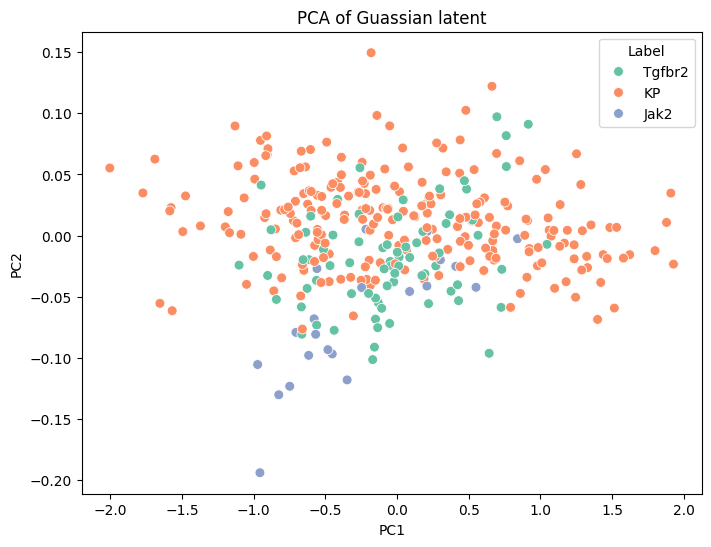

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(final_latent_[:,2:])
# Convert to DataFrame for easy plotting
df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df['Label'] = label
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', palette='Set2', s=50)
plt.title('PCA of Guassian latent')
plt.legend(title='Label')
plt.show()

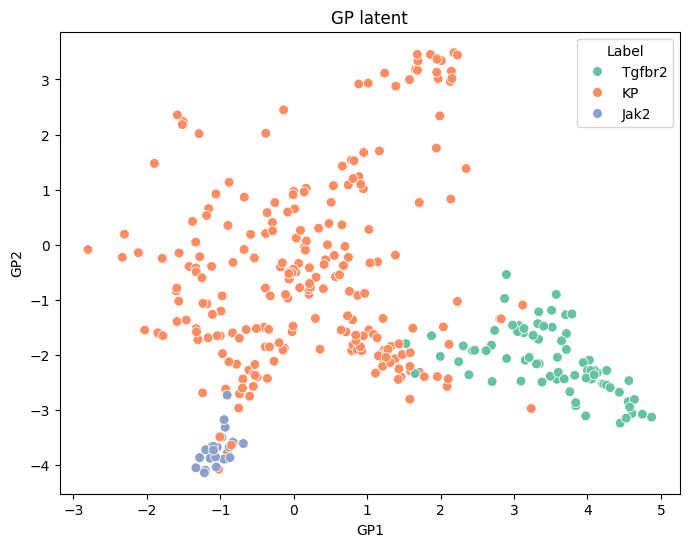

In [42]:
df = pd.DataFrame(final_latent_[:,0:2], columns=['GP1', 'GP2'])
df['Label'] = label
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='GP1', y='GP2', hue='Label', palette='Set2', s=50)
plt.title('GP latent')
plt.legend(title='Label')
plt.show()

## Get denoised and perturbed GEX

In [ ]:
denoised_counts, _ = model.batching_denoise_counts(X=loc, sample_index=sample_indices, cell_atts=cell_atts, batch_size=batch_size, n_samples=25)

In [ ]:
pert_ind = np.loadtxt('../pert_cells/pert_cells_GSM5808054_patchclose_tumor_Jak2.txt', dtype=int) - 1
target_cell_tissue = 'tumor'
target_cell_perturbation = 'Jak2'
perturbed_counts, pert_cell_att = model.counterfactualPrediction(X=loc, sample_index=sample_indices, cell_atts=cell_atts, batch_size=batch_size, n_samples=25, perturb_cell_id = pert_ind, 
                                                      target_cell_tissue = tissue_dic[target_cell_tissue], target_cell_perturbation = pert_dic[target_cell_perturbation])

In [50]:
data_mat = h5py.File('../datasets/GSM5808054_data.h5', 'r')
genes = np.array(data_mat['gene'], dtype=str)
data_mat.close()

In [55]:
gex = denoised_counts[:,np.where(genes=='Plac8')[0]]
gex_pert = perturbed_counts[:,np.where(genes=='Plac8')[0]]

### Plot GEX after denoising

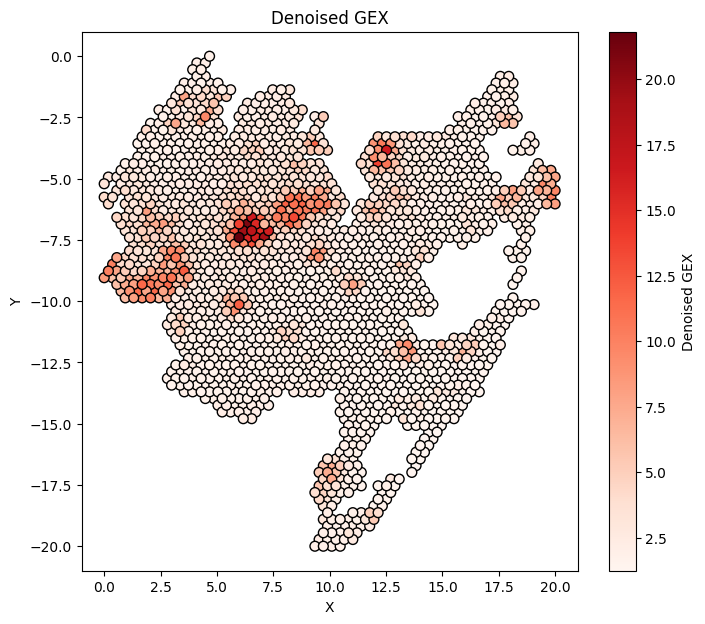

In [60]:
plt.figure(figsize=(8, 7))
sc = plt.scatter(loc[:,1], -loc[:,0], c=gex, cmap='Reds', edgecolor='k', s=50)
plt.colorbar(sc, label='Denoised GEX')
plt.title('Denoised GEX')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### Show spots to perturb

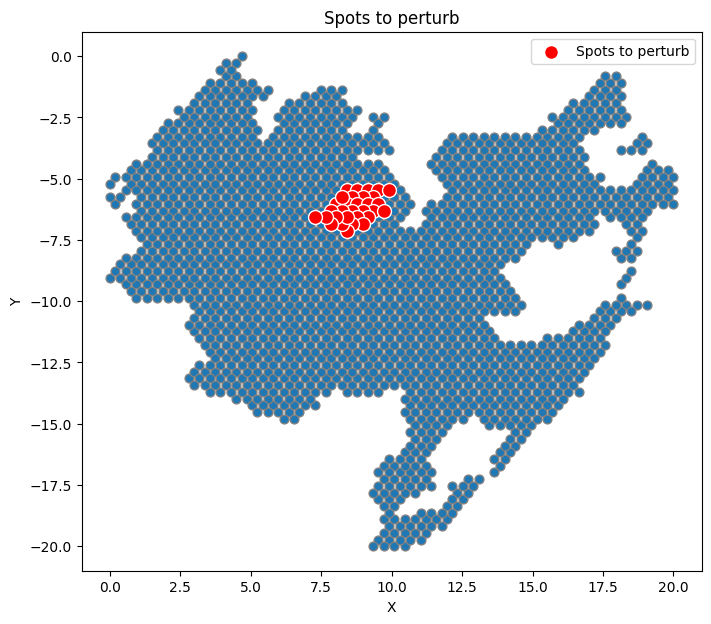

In [68]:
plt.figure(figsize=(8, 7))
sc = plt.scatter(loc[:,1], -loc[:,0], edgecolor='gray', s=40)
plt.scatter(loc[:,1][pert_ind], -loc[:,0][pert_ind], 
            color='red', edgecolor='white', s=100, marker='o', label='Spots to perturb')

# Colorbar and labels
plt.title('Spots to perturb')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### Plot GEX after in-silico perturbation

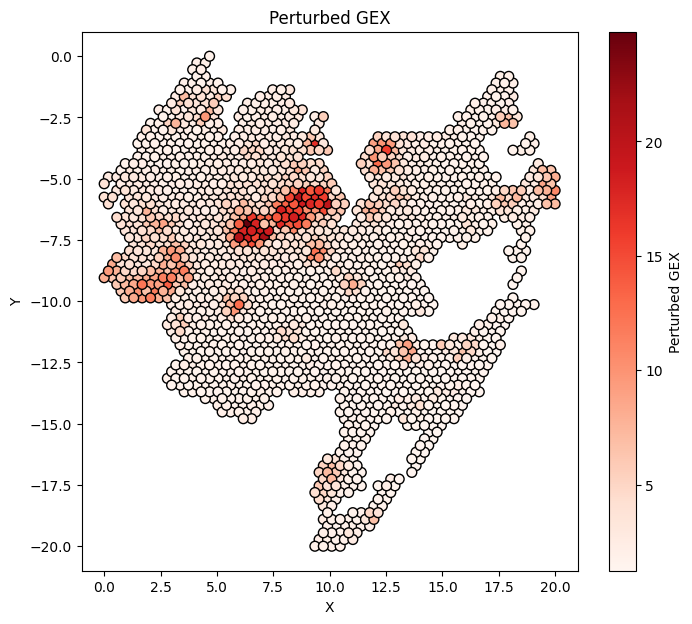

In [61]:
plt.figure(figsize=(8, 7))
sc = plt.scatter(loc[:,1], -loc[:,0], c=gex_pert, cmap='Reds', edgecolor='k', s=50)
plt.colorbar(sc, label='Perturbed GEX')
plt.title('Perturbed GEX')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()